In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torchvision import transforms
import torchvision.models as models
import numpy as np
import pandas as pd
import os
from skimage import io
from skimage import color
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from scipy.special import softmax
import matplotlib.pyplot as plt
import itertools
import time
import pdb
import re
from zipfile import ZipFile

device = torch.device('cuda')

torch.manual_seed(1117)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1117)

In [2]:
class BloodDataset(Dataset):
    """Blood Cell Images from https://www.kaggle.com/paultimothymooney/blood-cells."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.subfolder = ['EOSINOPHIL/', 'LYMPHOCYTE/', 'MONOCYTE/', 'NEUTROPHIL/']
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sf = self.subfolder[self.data_frame['label'].iloc[idx]]
        
        img_name = os.path.join(self.root_dir, sf, self.data_frame['filename'].iloc[idx])

        image = io.imread(img_name)
        
        # Added the following line to change image shape from (240, 320, 3) to (3, 240, 320)
        #image = np.repeat(image[None,...],3,axis=0)
        # Removed the above line, since it is not a clean transpose. Used following line instead.
        image = np.transpose(image, (2, 0, 1))
        
        image = (image - image.mean()) / image.std()
            
        image_class = self.data_frame['label'].iloc[idx]

        if self.transform:
            image = self.transform(image)
        
        sample = {'x': image, 'y': image_class}

        return sample

In [3]:
root = './blood-cells.zip'
partial_path = 'dataset2-master/dataset2-master/images/'
full_path = './blood-cells' + '/' + partial_path
batch_size = 4

dataset = {'train': BloodDataset('train.csv', full_path + 'TRAIN/'),
           'validate': BloodDataset('validate.csv', full_path + 'TRAIN/')}
train_validate_loader = {x: DataLoader(dataset[x], batch_size = batch_size, shuffle = True, num_workers = 0) for x in ['train', 'validate']}
test_loader = DataLoader(BloodDataset('test.csv', full_path + 'TEST/'), batch_size = 1, shuffle = True, num_workers = 0)
test_simple_loader = DataLoader(BloodDataset('test_simple.csv', full_path + 'TEST_SIMPLE/'), batch_size = 1, shuffle = True, num_workers = 0)

In [4]:
next(iter(train_validate_loader['train']))['x'].view(4, 3, -1).shape

torch.Size([4, 3, 76800])

# Add model here

In [5]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.res1a = nn.Conv2d(16, 16, 3, 1, 1)
        self.res1b = nn.Conv2d(16, 16, 3, 1, 1)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 64, 3, 2, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.res2a = nn.Conv2d(64, 64, 3, 1, 1)
        self.res2b = nn.Conv2d(64, 64, 3, 1, 1)
        
        self.fc1 = nn.Linear(19200, 1024)
        self.fc2 = nn.Linear(1024, 4)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
        
    def forward(self, x):
        out = self.conv1(x)
        
        residual = out
        out = self.res1a(out)
        out = F.relu(out)
        out = self.res1b(out)
        out += residual
        out = F.relu(out)
        
        out = self.conv2(out)
        
        residual = out
        out = self.res2a(out)
        out = F.relu(out)
        out = self.res2b(out)
        out += residual
        out = F.relu(out)
        
        out = self.fc1(out.view(out.shape[0], 1, -1))
        out = self.fc2(out)
        
        return out

In [6]:
model = MyCNN()

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
model.apply(weights_init)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 10 ** (-5))
lambda_func = lambda epoch: 0.5 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
loss_fn = nn.CrossEntropyLoss()

In [7]:
# Originally set num_epoch to 50, but the model stabilized ~11 epochs. I was going to set num_epoch to 15, but the model peaked at 15, so I set it to 20.
def train_model(model = model, dataloader = train_validate_loader, optimizer = optimizer, scheduler = scheduler, loss_fn = loss_fn, num_epoch = 20, verbose = True):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_loss = 1e5
    phases = ['train', 'validate']

    start_time = time.time()
    for epoch in range(num_epoch):
        print('Epoch: {}/{}'.format(epoch + 1, num_epoch))
        
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
            
            for data in dataloader[p]:
                optimizer.zero_grad()               
                image = torch.tensor(data['x']).to(device, dtype = torch.float)
                label = torch.tensor(data['y']).to(device, dtype = torch.long)
                output = model(image).squeeze(1)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds == label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
        
            epoch_acc = float(running_correct / running_total)
            epoch_loss = float(running_loss / running_total)
            
            if verbose or (i % 10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))
                
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            
            # Changed following to seek best epoch_loss, not epoch_acc
            if p == 'validate':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
            else:
                if scheduler:
                    scheduler.step()
        
        print('-'*10)
                    
    time_elapsed = time.time() - start_time
    print('Training/validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    
    return model, acc_dict, loss_dict

# Source: https://datascience.stackexchange.com/questions/37186/early-stopping-on-validation-loss-or-on-accuracy

In [8]:
model, acc_dict, loss_dict = train_model()

Epoch: 1/20


/home/mc8000/dl4med/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/mc8000/dl4med/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Phase:train, epoch loss: 2.1428 Acc: 0.4156
Phase:validate, epoch loss: 0.9913 Acc: 0.5664
----------
Epoch: 2/20
Phase:train, epoch loss: 0.7289 Acc: 0.6842
Phase:validate, epoch loss: 0.6697 Acc: 0.6989
----------
Epoch: 3/20
Phase:train, epoch loss: 0.4650 Acc: 0.8099
Phase:validate, epoch loss: 0.5648 Acc: 0.7635
----------
Epoch: 4/20
Phase:train, epoch loss: 0.2983 Acc: 0.8876
Phase:validate, epoch loss: 0.5265 Acc: 0.7768
----------
Epoch: 5/20
Phase:train, epoch loss: 0.2040 Acc: 0.9353
Phase:validate, epoch loss: 0.5045 Acc: 0.7864
----------
Epoch: 6/20
Phase:train, epoch loss: 0.1566 Acc: 0.9608
Phase:validate, epoch loss: 0.5167 Acc: 0.7872
----------
Epoch: 7/20
Phase:train, epoch loss: 0.1336 Acc: 0.9699
Phase:validate, epoch loss: 0.5040 Acc: 0.7933
----------
Epoch: 8/20
Phase:train, epoch loss: 0.1217 Acc: 0.9767
Phase:validate, epoch loss: 0.5036 Acc: 0.7957
----------
Epoch: 9/20
Phase:train, epoch loss: 0.1160 Acc: 0.9796
Phase:validate, epoch loss: 0.5041 Acc: 0.79

In [9]:
torch.save(model.state_dict(), './MyCNN_v20.pth')

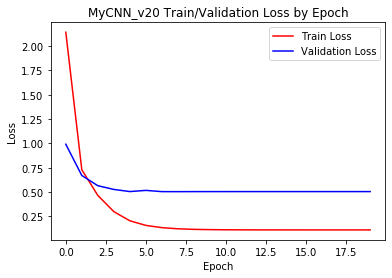

In [10]:
x = np.arange(len(loss_dict['train']))
plt.plot(x, loss_dict['train'], 'r', label="Train Loss")
plt.plot(x, loss_dict['validate'], 'b', label="Validation Loss")
plt.title('MyCNN_v20 Train/Validation Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('MyCNN_v20_loss.png')

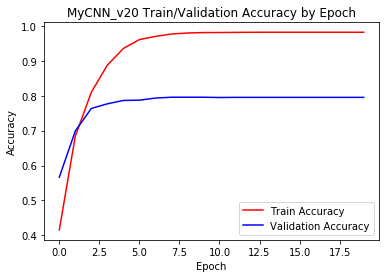

In [11]:
x = np.arange(len(acc_dict['train']))
plt.plot(x, acc_dict['train'], 'r', label="Train Accuracy")
plt.plot(x, acc_dict['validate'], 'b', label="Validation Accuracy")
plt.title('MyCNN_v20 Train/Validation Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('MyCNN_v20_accuracy.png')

In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    
    predictions = []
    probabilities = []
    actual = []
    
    running_total = len(test_loader)
    running_correct = 0
    
    with torch.no_grad():
        for data in test_loader:
            image = data['x'].to(device, dtype = torch.float)
            output = softmax(model(image).cpu()).view(-1).numpy()
            prediction = np.argmax(output)
            predictions.append(prediction)
            probabilities.append(output)

            label = data['y']
            actual.append(label)
            
            running_correct += torch.sum(prediction == label).item()
    
    probabilities = np.array(probabilities)
    accuracy = float(running_correct / running_total)
    
    return predictions, probabilities, actual, accuracy

In [13]:
model = MyCNN()
model.load_state_dict(torch.load('./MyCNN_v20.pth', map_location = torch.device('cpu')))
model.state_dict()
model = model.to(device)

predictions, probabilities, actual, accuracy = evaluate_model(model, test_loader)
print(accuracy)

0.6767189384800965


In [14]:
def plot_confusion_matrix(cm, target_names, title = 'Confusion Matrix', cmap = None, normalize = True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    print(accuracy, misclass)
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation = 45)
        plt.yticks(tick_marks, target_names)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('MyCNN_v20_cm.png')

0.6767189384800965 0.32328106151990355


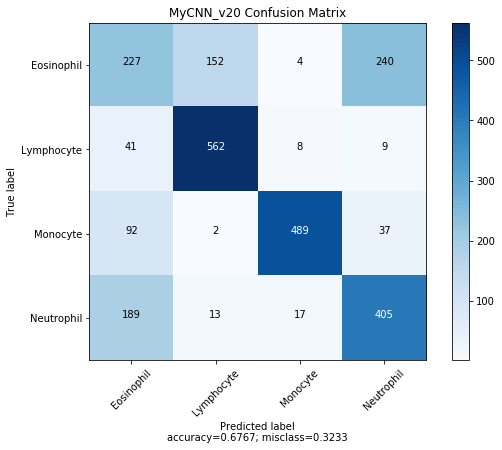

In [15]:
cm = metrics.confusion_matrix(actual, predictions)
target_names = ['Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
title = 'MyCNN_v20 Confusion Matrix'
cmap = None
normalize = False

plot_confusion_matrix(cm, target_names, title, cmap, normalize)

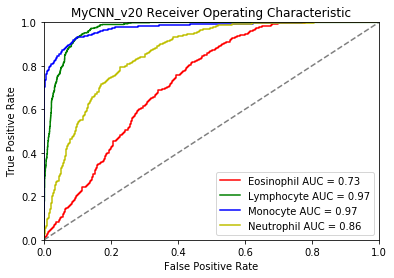

In [16]:
model_actual_binarized = np.array(label_binarize(actual, classes = [0, 1, 2, 3], pos_label = True))
n_classes = 4

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(model_actual_binarized[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

plt.figure()
plt.plot(fpr[0], tpr[0], 'r', label = 'Eosinophil AUC = %0.2f' % roc_auc[0])
plt.plot(fpr[1], tpr[1], 'g', label = 'Lymphocyte AUC = %0.2f' % roc_auc[1])
plt.plot(fpr[2], tpr[2], 'b', label = 'Monocyte AUC = %0.2f' % roc_auc[2])
plt.plot(fpr[3], tpr[3], 'y', label = 'Neutrophil AUC = %0.2f' % roc_auc[3])
plt.title('MyCNN_v20 Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('MyCNN_v20_auroc.png')

In [17]:
_, _, _, simple_accuracy = evaluate_model(model, test_simple_loader)
print(simple_accuracy)

0.4084507042253521
